In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf

from collections import Counter
from nltk.corpus import stopwords
from scipy import stats
from tensorflow.keras import losses, optimizers, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# if new methods are created in referenced codes, run the following code.
%reload_ext autoreload

## 初始化参数

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr


output_path = os.path.abspath('./output')
data_name = 'reviews_tf'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['Negative', 'Positive']

# 当binary_flag=True，auc的计算有些问题。回头有时间修复。
binary_flag=False
loss =  losses.SparseCategoricalCrossentropy(from_logits=True) if not binary_flag else losses.BinaryCrossentropy(from_logits=True)

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'Text',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 5000,
    'sequence_length': 100,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'binary_flag':binary_flag,
    'metrics':['accuracy', ], #, tf.keras.metrics.AUC(from_logits=True)
    'loss':loss,
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

## 获取数据

In [4]:
print('-'*25, 'Data Loading', '-'*25)
reviews_df=pd.read_csv('data/Reviews.csv')
print(reviews_df.shape)
display(reviews_df.head(5))

------------------------- Data Loading -------------------------
(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 探索数据

### 数据清理

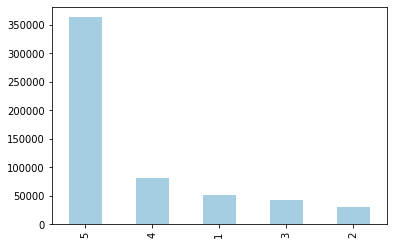

------------------------- Data Cleaning -------------------------
(568454, 2)


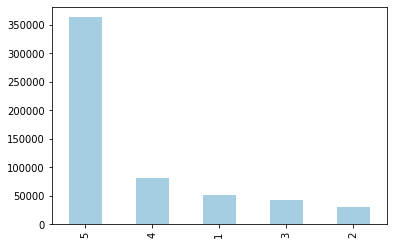

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


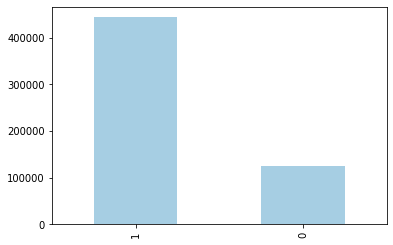

------------------------- 生成训练测试数据 -------------------------
train_texts.length=454763, train_labels.shape=(454763,)
test_texts.length=113691, test_labels.shape=(113691,)


In [5]:
# 评分分布
ax=reviews_df.Score.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

print('-'*25, 'Data Cleaning', '-'*25)
reviews_df = reviews_df[['Text','Score']].dropna()
print(reviews_df.shape)
# display(reviews_df.head(5))

# 评分分布
ax=reviews_df.Score.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

reviews_df.loc[reviews_df.Score<=3, 'Score']=0
reviews_df.loc[reviews_df.Score>3, 'Score']=1
display(reviews_df.head(5))

ax=reviews_df.Score.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

print('-'*25, '生成训练测试数据', '-'*25)
texts = list(reviews_df.Text) 
labels = np.array(reviews_df.Score)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, 
                                                                      test_size=0.2,
                                                                      random_state=202109)
print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

### 类别分布

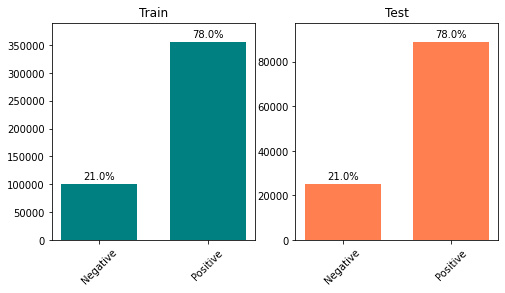

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)

### 文本长度分布

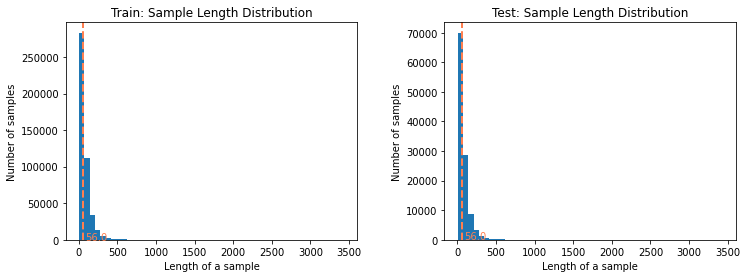

train：mean=80.24 variance=6301.19
test：mean=80.35 variance=6360.96


In [7]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [8]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,86028,20484,4753,1382,535,242,97,47,123,113691
train,344195,82336,18462,5572,2068,1047,379,203,501,454763
合计,430223,102820,23215,6954,2603,1289,476,250,624,568454


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,86044.751366,20564.036175,4643.008168,1390.802447,520.600916,257.800454,95.200167,50.000088,124.80022,113691.0
train,344178.248634,82255.963825,18571.991832,5563.197553,2082.399084,1031.199546,380.799833,199.999912,499.19978,454763.0
合计,430223.000000,102820.000000,23215.000000,6954.000000,2603.000000,1289.000000,476.000000,250.000000,624.00000,568454.0


然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [9]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 5.728532273156688
critical_value = 15.50731305586545
p_value = 0.6776101293599656


### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

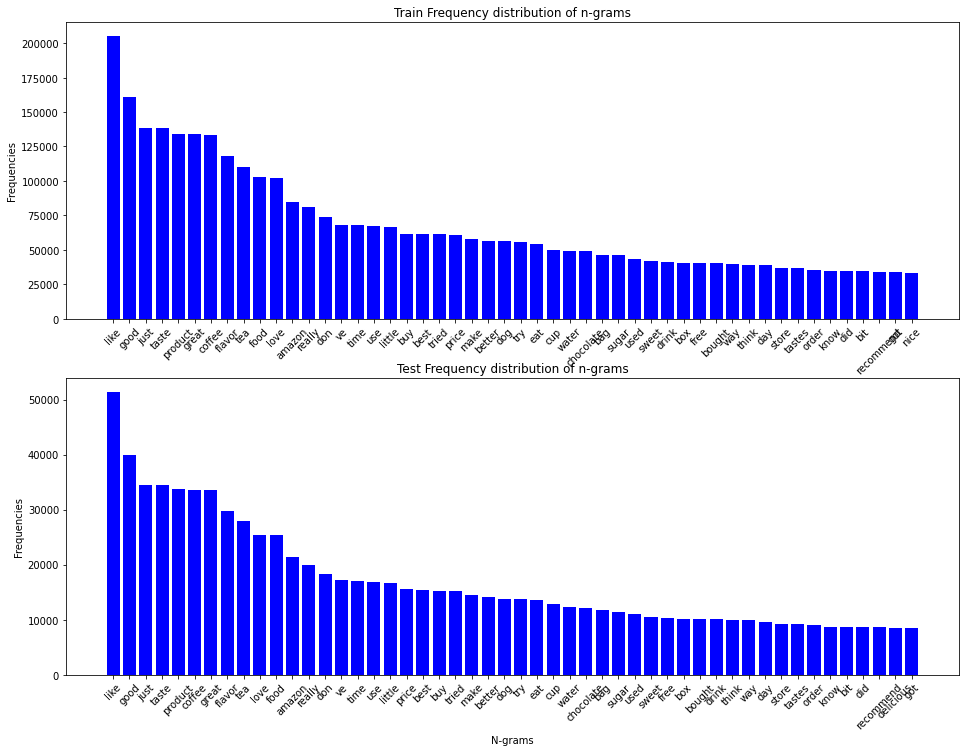

In [10]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [11]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<500: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 586944
Number of Vocabulary: 5758


## 数据准备

### Sequence + Preprocess

In [12]:
generator = qtf.classification.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                                 texts=train_texts, max_features=params.max_features, 
                                                 max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [13]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 100) (32,)
---------------------------------------- Positive ----------------------------------------
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   15 1248  315   14    6 1840 2151    5  614   40
   31    2 1004    1    7   69   10  267  787    5    4   57    7   17
  234 4227   11  342    5 1248   28  102   17   45 1005    5  476    8
 3811    1] (100,)
---------------------------------------- Negative ----------------------------------------
[  20   11   56   37   47    1    4   97  549    7   14    2  565 2450
    3 2243    2  284    3    5    7   24   14    2  310    1    4  137
   98  295   15  250   20    7  100 1145   14  800    5   64  168  273
    3   65 1613    1    4  128    6  225  343    3   30   21   91  536
  

### Sequence + Process

In [14]:
generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                                 standardize=qtf.text.standardize_tf_text1, 
                                                                 texts=train_texts, 
                                                                 max_features=params.max_features,
                                                                 max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [15]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 100) (32,)
---------------------------------------- Negative ----------------------------------------
[   3   93   38  255    7  174    6   30  182   39   29    1   11   11
  659   15 1792    8 4674  565  380    4  454    1  182   21   14  150
    8   45   81    6   24    1  152   23   37 1690  364   73 3443   42
   26  829 1007   11   11  107    8   45  341   24    2  829    3   72
   25   94   39    6   94 3690    3   93   73    1  829  644 3203    3
   19    5   41    1 2196    3 3119  184   60  491  277    1    8  829
   13   30  197 3443  182   11   11   76    3 3119    1 1007  155    4
   15   14] (100,)
---------------------------------------- Positive ----------------------------------------
[  10   49    9   67  148  147 2211    8  782    4 1062   85  689    6
    5 2659   39   72   25   39    2 1007   71   16   15    9  384   12
   53    2  223  321   45  762   13    5  122   16   20 4085   68    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [16]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-09-28 07:05:49,300: INFO: --------------------------------------------------------------------------------
2021-09-28 07:07:04,486: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-09-28 07:07:04,498: INFO: embedding_matrix.shape: (5000, 300)
2021-09-28 07:07:04,498: INFO: match count: 4963
2021-09-28 07:07:04,499: INFO: missing word count: 37


## 模型

### Embedding

#### embedding1

2021-09-28 07:07:04,972: INFO: model_params.embedding1.dropout=0.4
2021-09-28 07:07:04,972: INFO: model_params.embedding1.embedding_dim=200
2021-09-28 07:07:05,038: INFO: learning_rate=0.001
2021-09-28 07:07:05,039: INFO: model_params.embedding1.clip_value=None
2021-09-28 07:07:05,058: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1
2021-09-28 07:07:05,060: INFO: model_params.embedding1.epochs=15
2021-09-28 07:07:05,061: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1, monitor=val_accuracy)
2021-09-28 07:07:05,061: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-09-28 07:07:05,062: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-09-28 07:07:05,063: INFO: use LearningRateScheduler()
2021-09-28 07:07:05,063: INFO: steps_per_epoch=Non

TensorSpec(shape=(32, 100), dtype=tf.int32, name=None)
Model: "embedding1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     1000000     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 200)          0           embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 200)          0           embedding[0][0]                  
__________________________________

2021-09-28 07:08:36,756: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 2/15
14211/14211 [==============================] - 89s 6ms/step - loss: 0.2245 - accuracy: 0.9090 - val_loss: 0.2272 - val_accuracy: 0.9082
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:10:06,363: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 3/15
14211/14211 [==============================] - 89s 6ms/step - loss: 0.2010 - accuracy: 0.9203 - val_loss: 0.2197 - val_accuracy: 0.9132
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:11:35,888: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 4/15
14211/14211 [==============================] - 89s 6ms/step - loss: 0.1820 - accuracy: 0.9294 - val_loss: 0.2175 - val_accuracy: 0.9155
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:13:05,403: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 5/15
14211/14211 [==============================] - 90s 6ms/step - loss: 0.1667 - accuracy: 0.9366 - val_loss: 0.2181 - val_accuracy: 0.9170
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:14:35,901: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 6/15
14211/14211 [==============================] - 89s 6ms/step - loss: 0.1538 - accuracy: 0.9425 - val_loss: 0.2210 - val_accuracy: 0.9172
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:16:05,690: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 7/15
14211/14211 [==============================] - 89s 6ms/step - loss: 0.1428 - accuracy: 0.9474 - val_loss: 0.2254 - val_accuracy: 0.9173
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:17:35,193: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 8/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.1333 - accuracy: 0.9515 - val_loss: 0.2313 - val_accuracy: 0.9170
Epoch 9/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.1247 - accuracy: 0.9550 - val_loss: 0.2373 - val_accuracy: 0.9170
Epoch 10/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.1170 - accuracy: 0.9582 - val_loss: 0.2429 - val_accuracy: 0.9174
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


2021-09-28 07:22:00,959: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1/assets


Epoch 11/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.1099 - accuracy: 0.9612 - val_loss: 0.2500 - val_accuracy: 0.9163
Epoch 12/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.1036 - accuracy: 0.9639 - val_loss: 0.2569 - val_accuracy: 0.9160
Epoch 13/15
14211/14211 [==============================] - 90s 6ms/step - loss: 0.0977 - accuracy: 0.9663 - val_loss: 0.2646 - val_accuracy: 0.9160
Epoch 14/15
14211/14211 [==============================] - 89s 6ms/step - loss: 0.0923 - accuracy: 0.9685 - val_loss: 0.2725 - val_accuracy: 0.9156
Epoch 15/15
14211/14211 [==============================] - 91s 6ms/step - loss: 0.0872 - accuracy: 0.9705 - val_loss: 0.2809 - val_accuracy: 0.9151


2021-09-28 07:29:27,581: INFO: finish training [elapsed time: 1342.52 seconds]


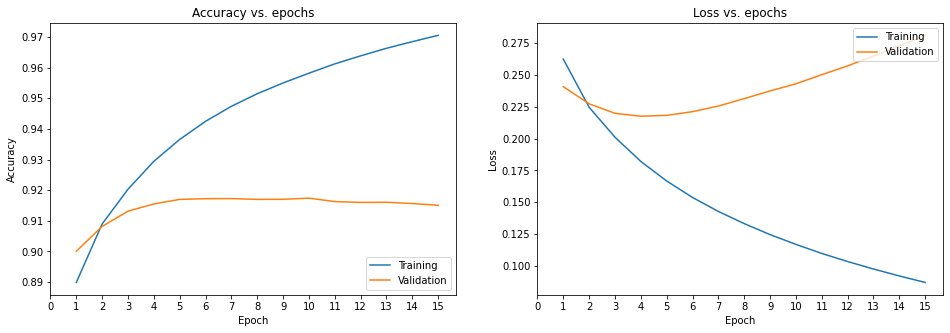

2021-09-28 07:29:28,044: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1
----------------------------------------evaluate----------------------------------------
y_score.shape=(454763, 2)
y_true.shape=(454763, 2)
len(y_true.shape)=2


2021-09-28 07:32:46,711: INFO: test loss:0.2429
2021-09-28 07:32:46,712: INFO: test accuracy:0.9174
2021-09-28 07:32:46,713: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/results.json
2021-09-28 07:32:46,715: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/results.json
2021-09-28 07:32:46,715: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_prepross.generator


y_score.shape=(113691, 2)
y_true.shape=(113691, 2)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------


2021-09-28 07:32:46,839: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_prepross.generator


----------------------------------------confusion matrix----------------------------------------


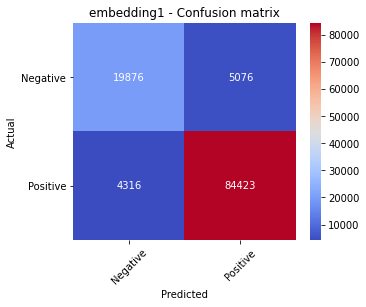

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding1,reviews_tf_0927.ipynb,1000802,1342.5,2021-09-28 07:32,0.0966,0.2429,0.9661,0.9174,0.9908,0.9538


In [17]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
model = qtf.classification.text_models.embedding1(helper, name='embedding1', binary_flag=params.binary_flag)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding2

2021-09-28 07:33:06,352: INFO: model_params.embedding2.dropout=0.4
2021-09-28 07:33:06,353: INFO: model_params.embedding2.embedding_dim=200
2021-09-28 07:33:06,381: INFO: learning_rate=0.001
2021-09-28 07:33:06,382: INFO: model_params.embedding2.clip_value=None
2021-09-28 07:33:06,387: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2
2021-09-28 07:33:06,390: INFO: model_params.embedding2.epochs=15
2021-09-28 07:33:06,391: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2, monitor=val_accuracy)
2021-09-28 07:33:06,391: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-09-28 07:33:06,392: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-09-28 07:33:06,392: INFO: use LearningRateScheduler()
2021-09-28 07:33:06,393: INFO: steps_per_epoch=Non

TensorSpec(shape=(32, 100), dtype=tf.int64, name=None)
Model: "embedding2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     1000000     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 200)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 200)          0           embedding_1[0][0]                
__________________________________

2021-09-28 07:35:53,378: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


Epoch 2/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.2316 - accuracy: 0.9059 - val_loss: 0.2354 - val_accuracy: 0.9054
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


2021-09-28 07:37:21,671: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


Epoch 3/15
14211/14211 [==============================] - 87s 6ms/step - loss: 0.2077 - accuracy: 0.9176 - val_loss: 0.2294 - val_accuracy: 0.9087
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


2021-09-28 07:38:48,965: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


Epoch 4/15
14211/14211 [==============================] - 88s 6ms/step - loss: 0.1887 - accuracy: 0.9268 - val_loss: 0.2276 - val_accuracy: 0.9107
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


2021-09-28 07:40:17,238: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


Epoch 5/15
14211/14211 [==============================] - 87s 6ms/step - loss: 0.1728 - accuracy: 0.9341 - val_loss: 0.2304 - val_accuracy: 0.9108
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


2021-09-28 07:41:45,035: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2/assets


Epoch 6/15
14211/14211 [==============================] - 86s 6ms/step - loss: 0.1597 - accuracy: 0.9401 - val_loss: 0.2339 - val_accuracy: 0.9101
Epoch 7/15
14211/14211 [==============================] - 86s 6ms/step - loss: 0.1485 - accuracy: 0.9451 - val_loss: 0.2389 - val_accuracy: 0.9098
Epoch 8/15
14211/14211 [==============================] - 87s 6ms/step - loss: 0.1387 - accuracy: 0.9494 - val_loss: 0.2438 - val_accuracy: 0.9101
Epoch 9/15
14211/14211 [==============================] - 86s 6ms/step - loss: 0.1299 - accuracy: 0.9532 - val_loss: 0.2506 - val_accuracy: 0.9092
Epoch 10/15
14211/14211 [==============================] - 86s 6ms/step - loss: 0.1222 - accuracy: 0.9564 - val_loss: 0.2583 - val_accuracy: 0.9081
Epoch 11/15
14211/14211 [==============================] - 86s 6ms/step - loss: 0.1151 - accuracy: 0.9591 - val_loss: 0.2644 - val_accuracy: 0.9084
Epoch 12/15
14211/14211 [==============================] - 87s 6ms/step - loss: 0.1087 - accuracy: 0.9617 - val_loss

2021-09-28 07:56:08,913: INFO: finish training [elapsed time: 1382.52 seconds]


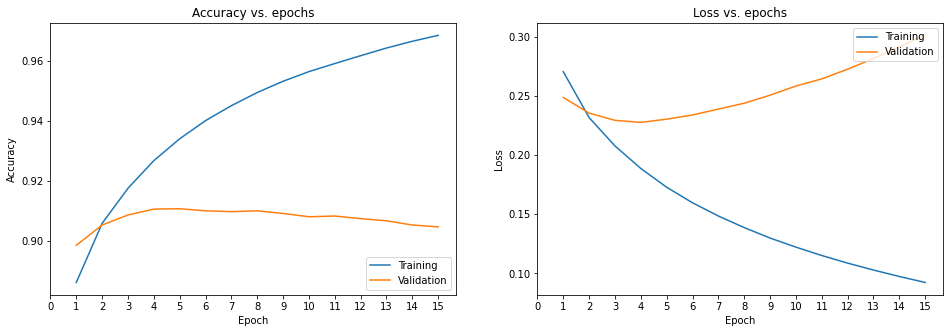

2021-09-28 07:56:09,319: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding2
----------------------------------------evaluate----------------------------------------
y_score.shape=(454763, 2)
y_true.shape=(454763, 2)
len(y_true.shape)=2


2021-09-28 08:01:03,947: INFO: test loss:0.2304
2021-09-28 08:01:03,948: INFO: test accuracy:0.9108
2021-09-28 08:01:03,950: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/results.json
2021-09-28 08:01:03,951: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/results.json
2021-09-28 08:01:03,952: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_map.generator


y_score.shape=(113691, 2)
y_true.shape=(113691, 2)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------


2021-09-28 08:01:03,956: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-09-28 08:01:03,995: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_map.layer/assets


2021-09-28 08:01:05,029: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_map.layer/assets
2021-09-28 08:01:05,053: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_map.generator
2021-09-28 08:01:05,054: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/embedding1


----------------------------------------confusion matrix----------------------------------------


2021-09-28 08:01:05,306: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/sequence_prepross.generator


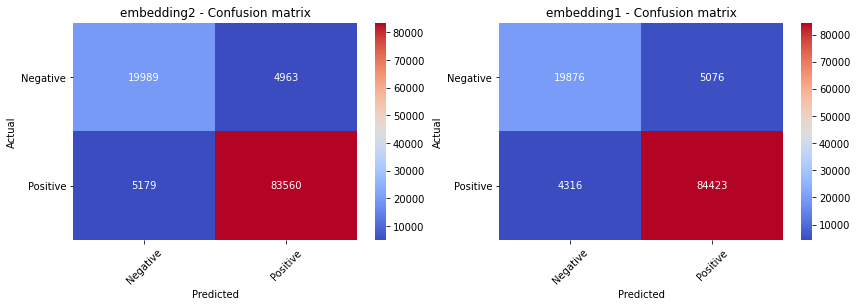

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding1,reviews_tf_0927.ipynb,1000802,1342.5,2021-09-28 07:32,0.0966,0.2429,0.9661,0.9174,0.9908,0.9538
2,embedding2,reviews_tf_0927.ipynb,1000802,1382.5,2021-09-28 08:01,0.1495,0.2304,0.9450,0.9108,0.9798,0.9517


In [18]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.embedding1(helper, name='embedding2', binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm', binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

2021-09-28 08:01:54,354: INFO: model_params.rnn_lstm.dropout=0.4
2021-09-28 08:01:54,355: INFO: model_params.rnn_lstm.units=200
2021-09-28 08:01:54,356: INFO: max_features=5000
2021-09-28 08:01:54,356: INFO: model_params.rnn_lstm.embedding_dim=200


TensorSpec(shape=(32, 100), dtype=tf.int64, name=None)


2021-09-28 08:01:55,122: INFO: learning_rate=0.001
2021-09-28 08:01:55,123: INFO: model_params.rnn_lstm.clip_value=None
2021-09-28 08:01:55,131: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm
2021-09-28 08:01:55,134: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm, monitor=val_accuracy)
2021-09-28 08:01:55,135: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-09-28 08:01:55,135: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-09-28 08:01:55,136: INFO: use LearningRateScheduler()
2021-09-28 08:01:55,137: INFO: steps_per_epoch=None
2021-09-28 08:01:55,137: INFO: start training
2021-09-28 08:01:55,138: INFO: use_class_weight=False


Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 200)          1000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 400)          641600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 2,123,002
Trainable params: 2,123,002
Non-trainable params: 0
________________________________________________

2021-09-28 08:08:06,765: WARNING: Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm/assets


2021-09-28 08:08:08,730: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm/assets


Epoch 2/10
14211/14211 [==============================] - 494s 35ms/step - loss: 0.1919 - accuracy: 0.9239 - val_loss: 0.1859 - val_accuracy: 0.9256


2021-09-28 08:16:36,882: WARNING: Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm/assets


2021-09-28 08:16:38,868: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm/assets


Epoch 3/10
14211/14211 [==============================] - 354s 25ms/step - loss: 0.1594 - accuracy: 0.9388 - val_loss: 0.1873 - val_accuracy: 0.9275


2021-09-28 08:22:46,710: WARNING: Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm/assets


2021-09-28 08:22:48,974: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/reviews_tf/reviews_tf_0927/rnn_lstm/assets


Epoch 4/10
 6480/14211 [============>.................] - ETA: 2:58 - loss: 0.1405 - accuracy: 0.9467

#### rnn_lstm_fasttext

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm_snps',
                 embedding_matrix=embedding_matrix_fasttext,
                 is_embedding_trainable=False,
                 mask_zero=False, binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_snps_simple', binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

#### pg_fasttext

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_ft',  
                       embedding_matrix=embedding_matrix_fasttext, 
                       is_embedding_trainable=False, binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=20)
helper.model_summary(model, history=history)

## 模型评估

### 预测更新

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 

In [ ]:
data_model_results.get_top_n(10, mode='df').columns

In [ ]:
data_model_results.show(5, columns=['test_loss', 'test_accuracy', 'model_path'])

In [ ]:
predictor = qtf.classification.Predictor.get_best_predictor(data_model_results)
# result_path = os.path.join(params.data_path, '{}_prediction.txt'.format(params.data_name))
# error_sample_path = os.path.join(params.data_path, '{}_error_sample.csv'.format(params.data_name))

# df_results, df_error_sample = qtf.text.save_predictions(reviews_df, 
#                                                         params.text_columns, 
#                                                         predictor,   
#                                                         result_path=result_path, 
#                                                         error_sample_path=error_sample_path,
#                                                         top_n=2
#                                                        )
# display(df_results.tail(5))
# print('-'*50)
# print(df_error_sample.groupby('label').size())
# print('-'*50)
# print(df_error_sample.groupby('top2_predict_correct').size())

### 更多Metrics

In [ ]:
predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 
                                 metrics.SparseTopKCategoricalAccuracy(k=2),
                                 'mae'])

results = predictor.evaluate(test_texts, test_labels)
print(results)

predictions = predictor.predict(test_texts)
print(predictions.shape)

In [ ]:
top1_predictions = predictor.predict_top_k(test_texts, test_labels, top_k=1)
top2_predictions = predictor.predict_top_k(test_texts, test_labels, top_k=2)

top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
top2_scores = qtf.utils.score(test_labels, top2_predictions, params.classes)

display(top1_scores)
# print('-'*100)
# display(top2_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))
# print('-'*100)
# print(classification_report(test_labels, top2_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_model_structure(predictor.model)